In [1]:
# !kaggle competitions download -c sf-dst-scoring

In [2]:
# !unzip sf-dst-scoring.zip

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    log_loss,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     train_test_split,
                                     KFold,
                                     StratifiedShuffleSplit,
                                     RepeatedStratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from gauss_rank_scaler import GaussRankScaler
import imblearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/Users/nikita/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
seed = 42

## Data overview

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.default = df_train.default.astype(int)

In [7]:
df_train.first_time.value_counts()

3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64

In [8]:
## Train
display(df_train.info())
display(df_train.describe().T)
display(df_train.describe(include='object').T)
display(df_train.isna().sum(0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

,count,mean,std,min,25%,50%,75%,max
client_id,73799.0,55137.965094,31841.921168,1.000000,27440.500000,55274.000000,82758.500000,110147.000000
age,73799.0,39.280641,11.520378,21.000000,30.000000,37.000000,48.000000,72.000000
decline_app_cnt,73799.0,0.275749,0.804272,0.000000,0.000000,0.000000,0.000000,33.000000
good_work,73799.0,0.164894,0.371087,0.000000,0.000000,0.000000,0.000000,1.000000
score_bki,73799.0,-1.904724,0.498231,-3.624586,-2.259534,-1.920823,-1.569831,0.199773
bki_request_cnt,73799.0,2.000339,2.252073,0.000000,0.000000,1.000000,3.000000,53.000000
region_rating,73799.0,56.725701,13.055717,20.000000,50.000000,50.000000,60.000000,80.000000
home_address,73799.0,1.575509,0.527631,1.000000,1.000000,2.000000,2.000000,3.000000
work_address,73799.0,2.496280,0.689818,1.000000,2.000000,3.000000,3.000000,3.000000
income,73799.0,41099.775417,46166.322400,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000


,count,unique,top,freq
app_date,73799,120,18MAR2014,1018
education,73492,5,SCH,38860
sex,73799,2,F,41562
car,73799,2,N,49832
car_type,73799,2,N,59791
foreign_passport,73799,2,N,62733


client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [9]:
## Test
display(df_test.info())
display(df_test.describe().T)
display(df_test.describe(include='object').T)
display(df_test.isna().sum(0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

None

,count,mean,std,min,25%,50%,75%,max
client_id,36349.0,54945.647473,31706.052195,4.000000,27744.000000,54657.000000,82322.000000,110148.00000
age,36349.0,39.186002,11.513258,21.000000,30.000000,37.000000,48.000000,71.00000
decline_app_cnt,36349.0,0.268040,0.788478,0.000000,0.000000,0.000000,0.000000,30.00000
good_work,36349.0,0.166772,0.372777,0.000000,0.000000,0.000000,0.000000,1.00000
score_bki,36349.0,-1.904152,0.501764,-3.574197,-2.261909,-1.920823,-1.563957,0.18882
bki_request_cnt,36349.0,2.014471,2.296789,0.000000,0.000000,1.000000,3.000000,47.00000
region_rating,36349.0,56.802938,13.086646,20.000000,50.000000,50.000000,60.000000,80.00000
home_address,36349.0,1.573798,0.527428,1.000000,1.000000,2.000000,2.000000,3.00000
work_address,36349.0,2.501087,0.683227,1.000000,2.000000,3.000000,3.000000,3.00000
income,36349.0,40835.755729,43802.180951,1000.000000,20000.000000,30000.000000,48000.000000,1000000.00000


,count,unique,top,freq
app_date,36349,120,18MAR2014,473
education,36178,5,SCH,19138
sex,36349,2,F,20274
car,36349,2,N,24458
car_type,36349,2,N,29349
foreign_passport,36349,2,N,30988


client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

0    0.873006
1    0.126994
Name: default, dtype: float64


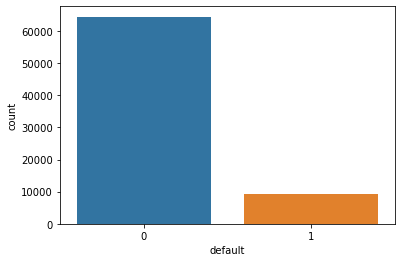

In [10]:
## Train
print(df_train['default'].value_counts(normalize=True))
sns.countplot(df_train['default']);

In [11]:
## Вывод -- классы очень несбалансированы. На это нужно обратить внимание при обучении модели, иначе есть риск переобучиться на самый популярный класс.

# Preprocessing

## Feature transformations

In [12]:
# Давайте сперва займёмся преобразованием признаков -- категориальные/бинарные закодируем, а числовые приведем к одному масштабу.

#### client_id

In [13]:
df_train.client_id.value_counts() # -- все id уникальны, просто отбросим эту колонку

6141     1
42113    1
29467    1
19228    1
21279    1
        ..
46588    1
48637    1
42494    1
87552    1
2049     1
Name: client_id, Length: 73799, dtype: int64

In [14]:
df_train.drop(columns=['client_id'], axis=0, inplace=True)
df_test.drop(columns=['client_id'], axis=0, inplace=True)

#### app_date

In [15]:
## Эта колонка -- дата подачи заявления. Давайте приведём её в приемлимый формат дат.

In [16]:
df_train.app_date

0        01FEB2014
1        12MAR2014
2        01FEB2014
3        23JAN2014
4        18APR2014
           ...    
73794    04MAR2014
73795    24MAR2014
73796    22APR2014
73797    04JAN2014
73798    23JAN2014
Name: app_date, Length: 73799, dtype: object

In [17]:
df_train.app_date = pd.to_datetime(df_train.app_date)
df_test.app_date = pd.to_datetime(df_test.app_date)

In [18]:
## Посмотрим на распределение подач заявлений по дням недели:
df_train.app_date.dt.day_name().value_counts()

Tuesday      12176
Monday       12024
Wednesday    11740
Thursday     11615
Friday       11263
Saturday      8231
Sunday        6750
Name: app_date, dtype: int64

In [19]:
df_test.app_date.dt.day_name().value_counts()

Tuesday      6004
Wednesday    5841
Monday       5834
Thursday     5806
Friday       5486
Saturday     3971
Sunday       3407
Name: app_date, dtype: int64

In [20]:
## Давайте посмотрим на распределение дефолтов по дням недели. Это поможет понять, нужно ли использовать день недели как признак.

In [21]:
df_train.groupby(df_train.app_date.dt.day_name())['default'].mean() ## <-- видно, что всё довольно равномерно

app_date
Friday       0.119950
Monday       0.127079
Saturday     0.130968
Sunday       0.129185
Thursday     0.131985
Tuesday      0.127382
Wednesday    0.124276
Name: default, dtype: float64

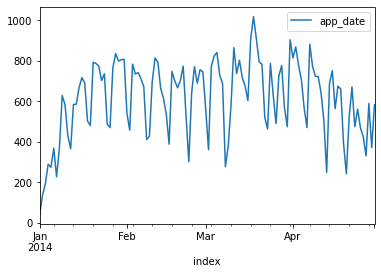

In [22]:
## Посмотрим на то, как часто подавали заявки в конкретный день:

df_train.app_date.value_counts().to_frame().reset_index().sort_values(by=['index']).plot.line(x='index', y='app_date');

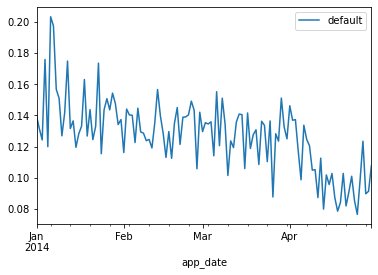

In [23]:
## Посмотрим на долю дефолтов в конкретный из дней:

df_train.groupby(df_train.app_date)['default'].mean().to_frame().reset_index().sort_values(by=['app_date']).plot.line(x='app_date', y='default')

In [24]:
df_train['month'] = df_train['app_date'].dt.month
df_test['month'] = df_test['app_date'].dt.month

df_train = pd.get_dummies(df_train, columns=['month'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['month'], drop_first=True)

In [25]:
# df_test.columns

In [26]:
# df_train.columns

In [27]:
df_train.drop(columns=['app_date'], inplace=True)
df_test.drop(columns=['app_date'], inplace=True)

## Outliers

In [28]:
# df_train['score_bki'] = np.abs(df_train['score_bki'].values)
# df_test['score_bki'] = np.abs(df_test['score_bki'].values)

In [29]:
def outliers(data):
    quantiles = np.percentile(data, [25, 75])
    iqr = quantiles[1] - quantiles[0]
    left = quantiles[0] - 1.5 * iqr
    right = quantiles[1] + 1.5 * iqr
    return left, right

In [30]:
for colname in ['bki_request_cnt', 'score_bki']:
    d = outliers(df_train[colname])
    df_train = df_train.loc[df_train[colname].between(d[0], d[1])]
    df_test = df_test.loc[df_test[colname].between(d[0], d[1])]

## OneHotEncoding

In [31]:
def do_ohe(train, test, column):
    test['default'] = None
    df_full = pd.concat([train, test], axis=0)
    dummies = pd.get_dummies(df_full[[column]], prefix=column, drop_first=True)
    df_full = pd.concat([df_full, dummies], axis=1).drop(columns=column)
    train = df_full[:train.shape[0]]
    test = df_full[train.shape[0]:]
    test = test.drop(columns=['default'])
    return train, test

In [32]:
df_train.describe(include='object').T

,count,unique,top,freq
education,71420,5,SCH,37905
sex,71718,2,F,40301
car,71718,2,N,48462
car_type,71718,2,N,58209
foreign_passport,71718,2,N,61043


In [33]:
df_train.region_rating.value_counts()

50    26832
60    15641
40    11769
80    11039
70     5940
30      295
20      202
Name: region_rating, dtype: int64

In [34]:
for col in ['sex', 'car', 'car_type', 'foreign_passport']: # , 'work_address', 'home_address', 'sna', 'first_time'
    df_train, df_test = do_ohe(df_train, df_test, col)

### Education

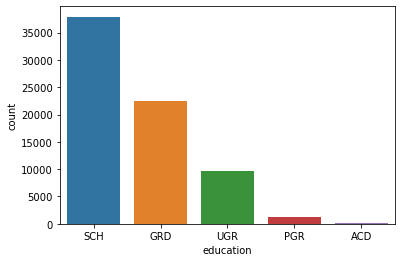

In [35]:
sns.countplot(df_train['education']);

In [36]:
df_train['education'].value_counts(dropna=False)

SCH    37905
GRD    22508
UGR     9614
PGR     1206
NaN      298
ACD      187
Name: education, dtype: int64

In [37]:
df_train.groupby(by=['education']).default.sum()

education
ACD       7
GRD    1937
PGR      77
SCH    5587
UGR    1247
Name: default, dtype: int64

In [38]:
# Заполним просто самым популярным значением -- 'SCH'

In [39]:
df_train.fillna(value='SCH', inplace=True)
df_test.fillna(value='SCH', inplace=True)

### Нормализация данных

In [40]:
def do_std_scale(train, test, column):
    scaler = StandardScaler()
    train[column] = scaler.fit_transform(train[[column]])
    test[column] = scaler.transform(test[[column]])
    
    return train, test

def do_gauss_scale(train, test, column):
    scaler = GaussRankScaler()
    train[column] = scaler.fit_transform(train[[column]])
    test[column] = scaler.transform(test[[column]])
    
    return train, test

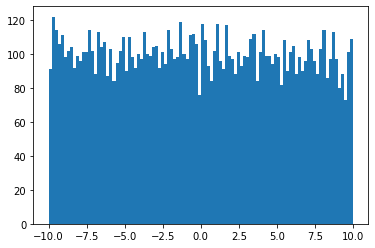

In [41]:
##### Пример ######


example = np.random.uniform(low=-10, high=10, size=10000)
plt.hist(example, bins=100);

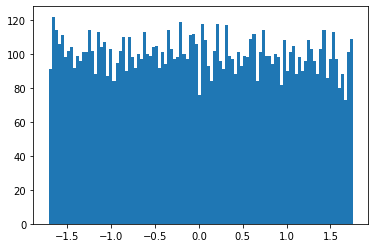

In [42]:
plt.hist(StandardScaler().fit_transform(example.reshape(-1, 1)), bins=100);

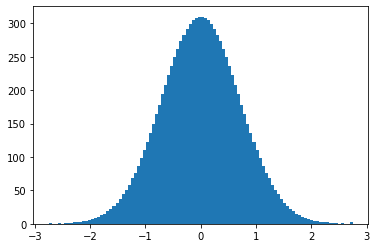

In [43]:
plt.hist(GaussRankScaler().fit_transform(example.reshape(-1, 1)), bins=100);

In [44]:
#####################

In [45]:
# for col in ['income', 'bki_request_cnt', 'decline_app_cnt', 'age']:
#     df_train, df_test = do_std_bscale(df_train, df_test, col)

In [46]:
df_train.columns

Index(['education', 'age', 'decline_app_cnt', 'good_work', 'score_bki',
       'bki_request_cnt', 'region_rating', 'home_address', 'work_address',
       'income', 'sna', 'first_time', 'default', 'month_2', 'month_3',
       'month_4', 'sex_M', 'car_Y', 'car_type_Y', 'foreign_passport_Y'],
      dtype='object')

In [47]:
np.unique(df_train.score_bki, return_counts=True)

(array([-3.28674961, -3.28385248, -3.2781226 , ..., -0.55171564,
        -0.55164499, -0.55099107]),
 array([1, 1, 4, ..., 1, 1, 1]))

In [48]:
df_train['comb1'] = (df_train.good_work + 1) * df_train.home_address * df_train.work_address * df_train.first_time
df_test['comb1'] = (df_test.good_work + 1) * df_test.home_address * df_test.work_address * df_test.first_time

df_train['comb2'] = (df_train.decline_app_cnt + 1) * df_train.score_bki * df_train.sna
df_test['comb2'] = (df_test.decline_app_cnt + 1) * df_test.score_bki * df_test.sna

df_train['comb3'] = df_train.sna * df_train.education.isin(['UGR', 'GDR', 'PGR', 'ACD'])
df_test['comb3'] =  df_test.sna * df_test.education.isin(['UGR', 'GDR', 'PGR', 'ACD'])

df_train, df_test = do_ohe(df_train, df_test, 'education')

In [49]:
root_columns = ['bki_request_cnt', 'income']

for col in root_columns:
    df_train[col + '_root'] = np.abs(df_train[col].values)**0.25
    df_test[col + '_root'] = np.abs(df_test[col].values)**0.25

In [50]:
for col in ['income', 'bki_request_cnt', 'decline_app_cnt', 'age']:
    df_train, df_test = do_gauss_scale(df_train, df_test, col)

In [51]:
for col in ['comb1', 'comb2', 'comb3']:
    df_train, df_test = do_gauss_scale(df_train, df_test, col)

In [52]:
for col in ['bki_request_cnt_root', 'income_root']:
    df_train, df_test = do_gauss_scale(df_train, df_test, col)

In [53]:
df_train.shape

(71718, 28)

In [54]:
df_test.shape

(35294, 27)

# Model training

In [55]:
X = df_train.drop(columns='default').values
y = df_train.default.values.astype(int)

In [56]:
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(-2, 2, 10),
}

## Naive way

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [58]:
print(f'In the initial dataset {np.unique(y, return_counts=True)[1] / y.shape[0]}')
print(f'In the training dataset {np.unique(y_train, return_counts=True)[1] / y_train.shape[0]}')
print(f'In the validation dataset {np.unique(y_val, return_counts=True)[1] / y_val.shape[0]}')

In the initial dataset [0.87608411 0.12391589]
In the training dataset [0.87642486 0.12357514]
In the validation dataset [0.87472114 0.12527886]


In [59]:
kf = KFold()

In [60]:
logreg = LogisticRegression(max_iter=500, random_state=seed)
gs = GridSearchCV(logreg, param_grid=param_grid, cv=kf, scoring='roc_auc')

In [61]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=500, random_state=42),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'penalty': ['l2']},
             scoring='roc_auc')

In [62]:
print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_estimator_.coef_)
print(df_train.columns)

LogisticRegression(C=100.0, max_iter=500, random_state=42)
0.7290119036675538
[[-0.0588067   0.15344154 -0.24311487  1.07508083  0.0697887  -0.02354293
   0.32319901  0.27717658 -0.03151772  0.06994352 -0.10295742 -0.0742362
  -0.09617608 -0.43274496  0.25626982 -0.01036136 -0.24073276 -0.24014622
   0.06812164 -0.16115654 -0.00559543  0.06395921  0.01631285  0.45027539
   0.34982781  0.0697887  -0.03151772]]
Index(['age', 'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'default', 'month_2', 'month_3', 'month_4', 'sex_M',
       'car_Y', 'car_type_Y', 'foreign_passport_Y', 'comb1', 'comb2', 'comb3',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'bki_request_cnt_root', 'income_root'],
      dtype='object')


In [63]:
probs = gs.predict_proba(X_val)
preds = gs.predict(X_val)
print('ROC AUC', roc_auc_score(y_val, probs[:, 1]))
print()
print('Confusion matrix: \n', confusion_matrix(y_val, preds))

ROC AUC 0.7267034991281973

Confusion matrix: 
 [[12511    36]
 [ 1772    25]]


## Correct way

In [64]:
s = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

In [65]:
train_ind, val_ind = list(s.split(X, y))[0]

In [66]:
X_train, X_val, y_train, y_val = X[train_ind], X[val_ind], y[train_ind], y[val_ind]

In [67]:
oversample_ups = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.8, random_state=seed)
X_train, y_train = oversample_ups.fit_resample(X_train, y_train)

In [68]:
oversample = imblearn.over_sampling.SMOTE(sampling_strategy=1., random_state=seed)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [69]:
print(f'In the initial dataset {np.unique(y, return_counts=True)[1] / y.shape[0]}')
print(f'In the training dataset {np.unique(y_train, return_counts=True)[1] / y_train.shape[0]}')
print(f'In the validation dataset {np.unique(y_val, return_counts=True)[1] / y_val.shape[0]}')

In the initial dataset [0.87608411 0.12391589]
In the training dataset [0.5 0.5]
In the validation dataset [0.87611545 0.12388455]


In [70]:
param_grid.update({'class_weight': ['balanced', {0: 1, 1: 10}]})

In [71]:
param_grid

{'penalty': ['l2'],
 'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
        5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
        3.59381366e+01, 1.00000000e+02]),
 'class_weight': ['balanced', {0: 1, 1: 10}]}

In [72]:
stratified_cv = RepeatedStratifiedKFold(n_repeats=2, random_state=seed)

In [73]:
logreg = LogisticRegression(max_iter=500, class_weight='balanced')
## На самом деле, здесь тоже есть даталик -- из-за апсемплинга есть шанс, что на валидации окажутся объекты из трейна.
## Правильнее будет делать апсемплинг уже после выбора n-1 fold'ов, а не до.
gs = GridSearchCV(logreg, param_grid=param_grid, cv=stratified_cv, scoring='roc_auc')

In [74]:
gs.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'class_weight': ['balanced', {0: 1, 1: 10}],
                         'penalty': ['l2']},
             scoring='roc_auc')

In [75]:
gs.best_params_

{'C': 0.0774263682681127, 'class_weight': 'balanced', 'penalty': 'l2'}

In [76]:
probs = gs.predict_proba(X_val)
preds = gs.predict(X_val)
print('ROC AUC', roc_auc_score(y_val, probs[:, 1]))
print()
print('Confusion matrix: \n', confusion_matrix(y_val, preds))

ROC AUC 0.7294220255737631

Confusion matrix: 
 [[8326 4241]
 [ 603 1174]]
